In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# # Load technical and fundamental data
stock = pd.read_csv("/content/sample.csv")
# data = pd.read_csv("/content/Data.csv")

In [ ]:
stock.shape

(1082, 2)

In [ ]:
#merge using outer join
# df = pd.merge(stock, data, on="Date",how = "outer")
df = stock.copy()

In [ ]:
df.shape

(1082, 2)

In [ ]:
df.head()

,time,close
0,1751328000000,65.37
1,1751241600000,64.87
2,1750982400000,64.56
3,1750896000000,64.98
4,1750809600000,64.59


In [ ]:
df.tail()

,time,close
1077,1563926400000,59.28
1078,1551657600000,61.49
1079,1548115200000,62.50
1080,1548028800000,62.45
1081,1547596800000,63.56


In [ ]:
df.isnull().sum()

,0
time,0
close,0


In [ ]:
df.rename(columns = {'close':'Price'},inplace = True)

In [ ]:
df

,time,Price
0,1751328000000,65.37
1,1751241600000,64.87
2,1750982400000,64.56
3,1750896000000,64.98
4,1750809600000,64.59
...,...,...
1077,1563926400000,59.28
1078,1551657600000,61.49
1079,1548115200000,62.50
1080,1548028800000,62.45


In [ ]:
# df['Price'] = df['Price'].fillna(df['Price'].rolling(window=5, min_periods=1).mean())
# df['Data'] = df['Data'].fillna(df['Data'].rolling(window=5, min_periods=1).mean())

In [ ]:
df.isnull().sum()

,0
time,0
Price,0


In [ ]:
import plotly.express as px

fig1 = px.line(df, x='time', y='Price', title="Price Trend")
fig1.update_traces(mode="lines+markers", hoverinfo="all")
fig1.show()


In [ ]:
df = df.sort_values(by="time", ascending=True)

In [ ]:
df.drop(columns=['time'],inplace = True)

In [ ]:
df.reset_index(drop=True, inplace=True)

Original Data:
      Price
0     63.56
1     62.45
2     62.50
3     61.49
4     59.28
...     ...
1077  64.59
1078  64.98
1079  64.56
1080  64.87
1081  65.37

[1082 rows x 1 columns]

Filtered Data:
       Price
0     59.445
1     59.280
2     58.855
3     61.490
4     59.280
...      ...
1077  67.650
1078  64.980
1079  67.805
1080  64.870
1081  65.370

[1082 rows x 1 columns]


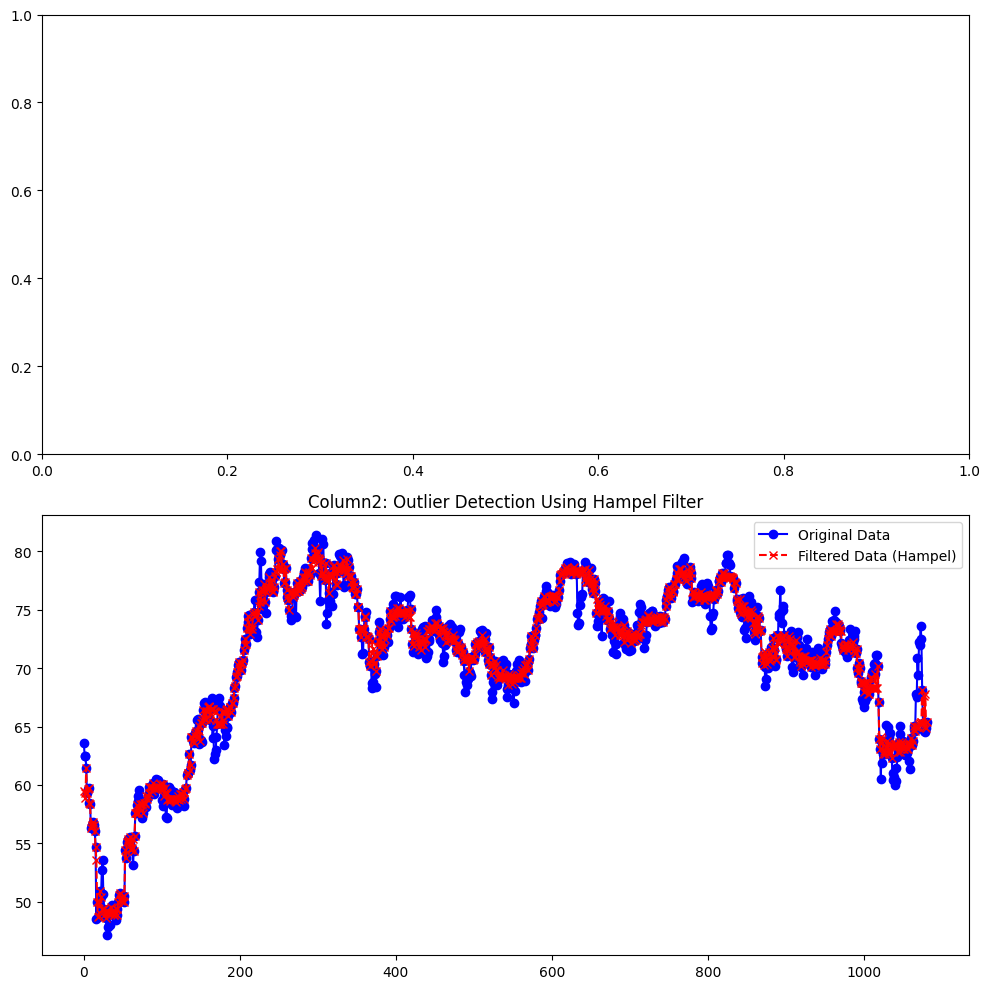

In [ ]:
def hampel_filter(data, window_size=3, k=1):
    """
    Hampel filter for outlier detection applied to each column of a DataFrame.

    :param data: A pandas DataFrame or Series with multiple columns
    :param window_size: Size of the sliding window (odd number)
    :param k: The threshold constant
    :return: A pandas DataFrame with outliers replaced by the median of their window
    """
    if isinstance(data, pd.Series):
        data = data.to_frame()

    filtered_data = data.copy()  # Copy original data to avoid modifying it directly

    # Apply Hampel filter for each column
    for column in data.columns:
        # Convert column to pandas Series
        series = data[column]

        # Half the window size for sliding window
        half_window = window_size // 2

        # Loop through each value in the column
        for i in range(len(series)):
            start = max(0, i - half_window)
            end = min(len(series), i + half_window + 1)

            window = series[start:end]
            median = window.median()
            deviation = np.abs(window - median)
            median_deviation = deviation.median()

            # If the deviation of the current point is greater than k * median_deviation, it's an outlier
            if deviation.iloc[half_window] > k * median_deviation:
                filtered_data.at[i, column] = median  # Replace outlier with the median

    return filtered_data

filtered_df = hampel_filter(df, window_size=23, k=1)

print("Original Data:")
print(df)
print("\nFiltered Data:")
print(filtered_df)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot Column1
# axes[0].plot(df['Data'], label='Original Data', marker='o', linestyle='-', color='b')
# axes[0].plot(filtered_df['Data'], label='Filtered Data (Hampel)', marker='x', linestyle='--', color='r')
# axes[0].set_title('Column1: Outlier Detection Using Hampel Filter')
# axes[0].legend()

# Plot Column2
axes[1].plot(df['Price'], label='Original Data', marker='o', linestyle='-', color='b')
axes[1].plot(filtered_df['Price'], label='Filtered Data (Hampel)', marker='x', linestyle='--', color='r')
axes[1].set_title('Column2: Outlier Detection Using Hampel Filter')
axes[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
filtered_df.head()

,Price
0,59.445
1,59.280
2,58.855
3,61.490
4,59.280


In [ ]:
df.head()

,Price
0,63.56
1,62.45
2,62.50
3,61.49
4,59.28


In [ ]:
df.isnull().sum()

,0
Price,0


In [ ]:
filtered_df.isnull().sum()

,0
Price,0


In [ ]:
#split data
X = filtered_df
y = df[['Price']]

In [ ]:
X.shape,y.shape

((1082, 1), (1082, 1))

In [ ]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [ ]:
X

array([[0.34255454],
       [0.33733797],
       [0.32390136],
       ...,
       [0.60686058],
       [0.51406892],
       [0.5298767 ]])

In [ ]:
y

array([[0.47998831],
       [0.44756062],
       [0.44902133],
       ...,
       [0.50920245],
       [0.51825884],
       [0.53286591]])

In [ ]:
train_size = int(len(X) * 0.65)
validation_size = int(len(X) * 0.15)
test_size = len(X) - train_size - validation_size  # Remaining data will be for the test set

# Split the data into training, validation, and test sets
train_data, validation_data, test_data = X[:train_size], X[train_size:train_size + validation_size], X[train_size + validation_size:]
train_target, validation_target, test_target = y[:train_size], y[train_size:train_size + validation_size], y[train_size + validation_size:]

print(f'Training data size: {train_data.shape}')
print(f'Validation data size: {validation_data.shape}')
print(f'Test data size: {test_data.shape}')


Training data size: (703, 1)
Validation data size: (162, 1)
Test data size: (217, 1)


In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(data,target, time_step=1):
	dataX, dataY = [], []
	for i in range(len(data)-time_step-1):
		a = data[i:(i+time_step), :]
		dataX.append(a)
		dataY.append(target[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 4 #optimal value
X_train, y_train = create_dataset(train_data,train_target, time_step)
X_valid,y_valid = create_dataset(validation_data,validation_target,time_step)
X_test, ytest = create_dataset(test_data,test_target, time_step)

In [ ]:
X_train.shape,y_train.shape

((699, 3, 1), (699,))

In [ ]:
X_valid.shape,y_valid.shape

((158, 3, 1), (158,))

In [ ]:
X_test.shape,ytest.shape

((213, 3, 1), (213,))

In [ ]:
#model architecture
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['root_mean_squared_error'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Model Training with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.4620 - root_mean_squared_error: 0.6793 - val_loss: 0.4477 - val_root_mean_squared_error: 0.6691
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2345 - root_mean_squared_error: 0.4822 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - root_mean_squared_error: 0.1712 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0182 - root_mean_squared_error: 0.1346 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score: 1.47 RMSE
Validation Score: 1.03 RMSE
Test Score: 1.87 RMSE
Train R2 Score: 0.97
Validation R2 Score: 0.69
Test R2 Score: 0.76


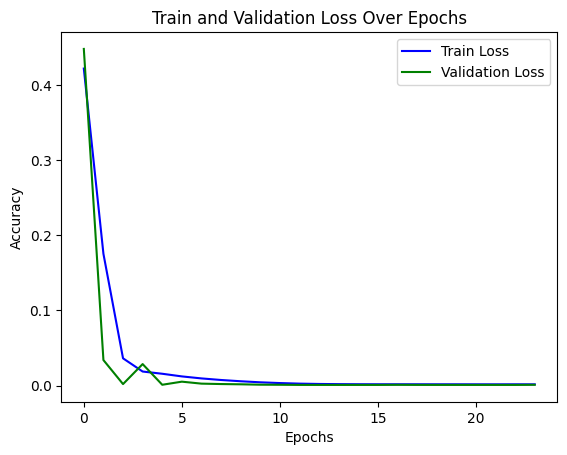

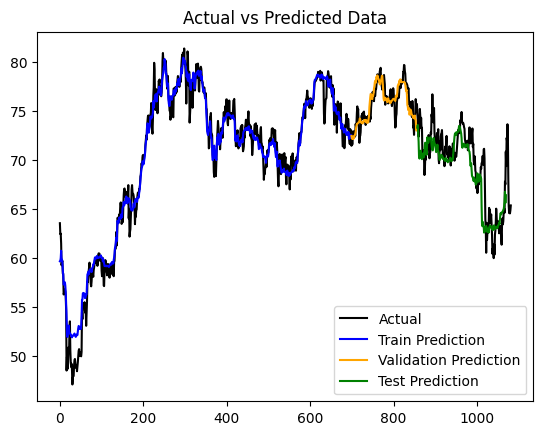

In [ ]:
# Predict on train, validation, and test sets
from sklearn.metrics import r2_score
train_size = len(X_train)
test_size = len(X_test)
validation_size = len(X_valid)
total_size = train_size + test_size + validation_size
train_predict = model.predict(X_train)
validation_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

# Inverse transform each dataset separately
train_predict_inv = scaler.inverse_transform(train_predict)
train_target_inv = scaler.inverse_transform([y_train])

validation_predict_inv = scaler.inverse_transform(validation_predict)
validation_target_inv = scaler.inverse_transform([y_valid])

test_predict_inv = scaler.inverse_transform(test_predict)
test_target_inv = scaler.inverse_transform([ytest])

# Calculate Root Mean Squared Error (RMSE) for train, validation, and test
train_score = np.sqrt(np.mean((train_target_inv[0] - train_predict_inv[:, 0]) ** 2))
print(f'Train Score: {train_score:.2f} RMSE')

validation_score = np.sqrt(np.mean((validation_target_inv[0] - validation_predict_inv[:, 0]) ** 2))
print(f'Validation Score: {validation_score:.2f} RMSE')

test_score = np.sqrt(np.mean((test_target_inv[0] - test_predict_inv[:, 0]) ** 2))
print(f'Test Score: {test_score:.2f} RMSE')

# Calculate R2 Score for train, validation, and test
print(f'Train R2 Score: {r2_score(train_target_inv[0], train_predict_inv[:, 0]):.2f}')
print(f'Validation R2 Score: {r2_score(validation_target_inv[0], validation_predict_inv[:, 0]):.2f}')
print(f'Test R2 Score: {r2_score(test_target_inv[0], test_predict_inv[:, 0]):.2f}')

# Plotting train, validation, and test accuracy over epochs
# If you have history from training, use this for plotting training loss
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

plt.plot(train_accuracy, label='Train Loss', color='blue')
plt.plot(val_accuracy, label='Validation Loss', color='green')
plt.title('Train and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot actual data vs predictions (train, validation, and test)
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(train_predict_inv), :] = train_predict_inv

# Shift validation predictions for plotting
validationPredictPlot = np.empty_like(y)
validationPredictPlot[:, :] = np.nan
validationPredictPlot[train_size:train_size + validation_size, :] = validation_predict_inv

# Shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[train_size + validation_size:total_size, :] = test_predict_inv

# Plot actual data and predictions (train, validation, and test)
plt.plot(scaler.inverse_transform(y), label='Actual', color='black')
plt.plot(trainPredictPlot, label='Train Prediction', color='blue')
plt.plot(validationPredictPlot, label='Validation Prediction', color='orange')
plt.plot(testPredictPlot, label='Test Prediction', color='green')
plt.legend(loc='best')
plt.title('Actual vs Predicted Data')
plt.show()

In [ ]:
test_predict_inv

array([[73.291435],
       [73.56377 ],
       [72.64633 ],
       [71.862404],
       [70.34364 ],
       [70.14292 ],
       [70.38471 ],
       [70.323006],
       [70.94811 ],
       [70.74072 ],
       [70.33402 ],
       [70.083626],
       [70.407745],
       [70.477   ],
       [70.66519 ],
       [70.26473 ],
       [70.5347  ],
       [70.966995],
       [71.55761 ],
       [71.76012 ],
       [71.12074 ],
       [70.946556],
       [70.51951 ],
       [71.21799 ],
       [72.31568 ],
       [72.03467 ],
       [71.74384 ],
       [71.89012 ],
       [72.16536 ],
       [72.17788 ],
       [72.21382 ],
       [72.30523 ],
       [72.28617 ],
       [72.12681 ],
       [71.536095],
       [71.22715 ],
       [71.015076],
       [70.97969 ],
       [71.68282 ],
       [72.24188 ],
       [71.967834],
       [71.697205],
       [71.64762 ],
       [71.454544],
       [71.173904],
       [70.80271 ],
       [71.248276],
       [71.03974 ],
       [71.558846],
       [70.953735],


In [ ]:
actual = test_target_inv.flatten()
predicted = test_predict_inv.flatten()

# Create a DataFrame
test_results_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

In [ ]:
test_results_df

,Actual,Predicted
0,73.29,73.291435
1,70.94,73.563766
2,70.43,72.646332
3,71.00,71.862404
4,70.30,70.343643
...,...,...
208,65.33,65.285553
209,64.59,65.811951
210,64.98,66.756744
211,64.56,65.621727


In [ ]:
test_results_df['Actual_prev'] = test_results_df['Actual'].shift(1)
test_results_df['Predicted_prev'] = test_results_df['Predicted'].shift(1)

In [ ]:
test_results_df.dropna(inplace=True)

In [ ]:
test_results_df['Actual_change'] = np.where(
    (test_results_df['Actual'] - test_results_df['Actual_prev']) > 0, 1, 0
)

test_results_df['Predicted_change'] = np.where(
    (test_results_df['Predicted'] - test_results_df['Predicted_prev']) > 0, 1, 0
)

In [ ]:
(test_results_df['Actual_change'] == test_results_df['Predicted_change']).sum()

np.int64(108)